<h2 style="color:#1f77b4;">Live Coding Parte 1</h2>

In [1]:
import sys
import numpy as np
import pandas as pd

print("Python:", sys.version.split()[0])
print("Ejecutable:", sys.executable)
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)


Python: 3.11.13
Ejecutable: /opt/anaconda3/envs/bootcamp/bin/python
NumPy: 2.0.1
Pandas: 2.3.1


<h5 style="color:#1f77b4;">1. Generar un dataset de ejemplo.</h5>

dataset “Ventas PyME”

In [3]:
np.random.seed(42)

n = 30000
df_demo = pd.DataFrame({
    "fecha": pd.date_range("2025-01-01", periods=n, freq="D"),
    "sucursal": np.random.choice(["Centro", "Norte", "Sur"], size=n, p=[0.5, 0.3, 0.2]),
    "canal": np.random.choice(["Online", "Tienda", "Mayorista"], size=n, p=[0.4, 0.45, 0.15]),
    "categoria": np.random.choice(["Abarrotes", "Limpieza", "Bebidas"], size=n),
    "unidades": np.random.poisson(lam=12, size=n).astype(float),
    "precio_unitario": np.round(np.random.normal(loc=6500, scale=1200, size=n), 0).astype(float),
    "descuento_pct": np.round(np.clip(np.random.normal(loc=0.08, scale=0.06, size=n), 0, 0.35), 2),
})
# Ventas (monto) base
df_demo["ventas"] = np.round(df_demo["unidades"] * df_demo["precio_unitario"] * (1 - df_demo["descuento_pct"]), 0)

# 1) Falta descuento más seguido en canal Tienda (patrón realista)
mask_desc = (df_demo["canal"] == "Tienda") & (np.random.rand(n) < 0.35)
df_demo.loc[mask_desc, "descuento_pct"] = np.nan

# 2) Falta precio_unitario en algunos registros (errores de carga)
mask_precio = np.random.rand(n) < 0.12
df_demo.loc[mask_precio, "precio_unitario"] = np.nan

# 3) Falta canal en pocos casos (dato categórico)
mask_canal = np.random.rand(n) < 0.10
df_demo.loc[mask_canal, "canal"] = np.nan

# ---- OUTLIERS ----
# Un día con venta extremadamente alta (outlier)
df_demo.loc[np.random.choice(df_demo.index, 1), "ventas"] *= 8

# Precio unitario extremadamente alto (outlier)
df_demo.loc[np.random.choice(df_demo.index, 1), "precio_unitario"] *= 5

# Unidades extremadamente altas (outlier)
df_demo.loc[np.random.choice(df_demo.index, 1), "unidades"] *= 6

df_demo.head(10)


,fecha,sucursal,canal,categoria,unidades,precio_unitario,descuento_pct,ventas
0,2025-01-01,Centro,Tienda,Bebidas,6.0,7523.0,0.00,45138.0
1,2025-01-02,Sur,Tienda,Abarrotes,11.0,6228.0,NaN,56862.0
2,2025-01-03,Norte,Mayorista,Limpieza,15.0,6861.0,0.18,84390.0
3,2025-01-04,Norte,Online,Bebidas,14.0,7972.0,0.03,108260.0
4,2025-01-05,Centro,Tienda,Bebidas,11.0,7358.0,NaN,77700.0
5,2025-01-06,Centro,NaN,Abarrotes,8.0,NaN,0.12,40438.0
6,2025-01-07,Centro,NaN,Limpieza,20.0,NaN,NaN,146302.0
7,2025-01-08,Sur,Tienda,Limpieza,11.0,7188.0,0.00,79068.0
8,2025-01-09,Norte,Tienda,Bebidas,14.0,6292.0,NaN,80160.0
9,2025-01-10,Norte,Online,Limpieza,10.0,4264.0,0.00,42640.0


<h5 style="color:#1f77b4;">2. Detectar valores perdidos con isnull() y contarlos.</h5>

In [21]:
df_demo.shape

(30000, 8)

In [22]:
df_demo.isnull().sum()

fecha                 0
sucursal              0
canal              3009
categoria             0
unidades              0
precio_unitario    3697
descuento_pct      4640
ventas                0
dtype: int64

In [23]:
nulos = df_demo.isnull().sum()
porcentaje = (df_demo.isnull().mean() * 100).round(2)

resumen_nulos = pd.DataFrame({
    "nulos": nulos,
    "porcentaje_%": porcentaje
}).sort_values("nulos", ascending=False)

resumen_nulos



,nulos,porcentaje_%
descuento_pct,4640,15.47
precio_unitario,3697,12.32
canal,3009,10.03
fecha,0,0.00
categoria,0,0.00
sucursal,0,0.00
unidades,0,0.00
ventas,0,0.00


In [24]:
total_nulos = df_demo.isnull().sum().sum()
filas_con_nulos = df_demo.isnull().any(axis=1).sum()

print("Total de nulos en el dataset:", total_nulos)
print("Filas con al menos un nulo:", filas_con_nulos)


Total de nulos en el dataset: 11346
Filas con al menos un nulo: 10016


<h5 style="color:#1f77b4;">3. Visualizar datos faltantes con missingno y Seaborn.</h5>

Missingno: matriz de nulos<br>
* Negro/gris = dato presente
* Blanco = dato faltante

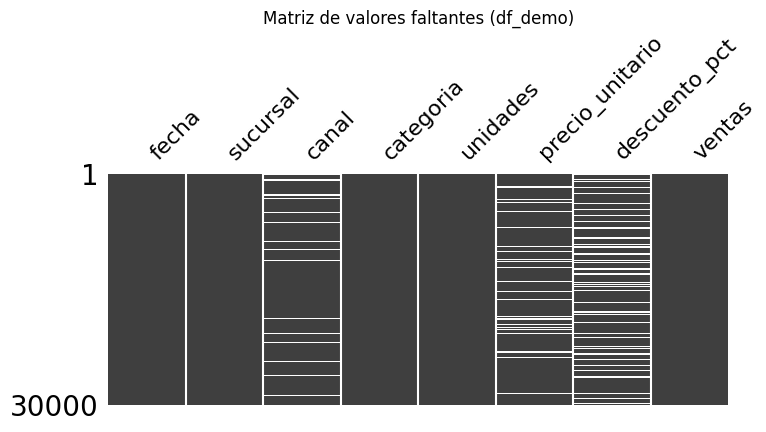

In [26]:
import missingno as msno
import matplotlib.pyplot as plt

msno.matrix(df_demo, figsize=(8, 3), sparkline=False)
plt.title("Matriz de valores faltantes (df_demo)")
plt.show()


Seaborn: heatmap de isnull()

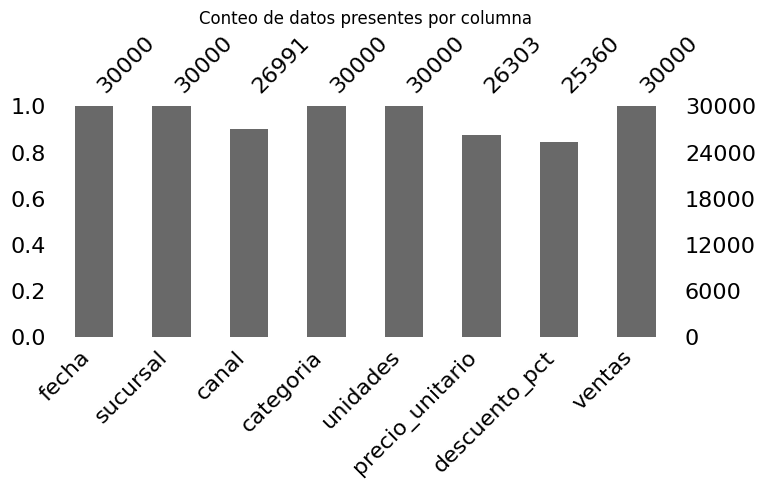

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

msno.bar(df_demo, figsize=(8, 3))
plt.title("Conteo de datos presentes por columna")
plt.show()


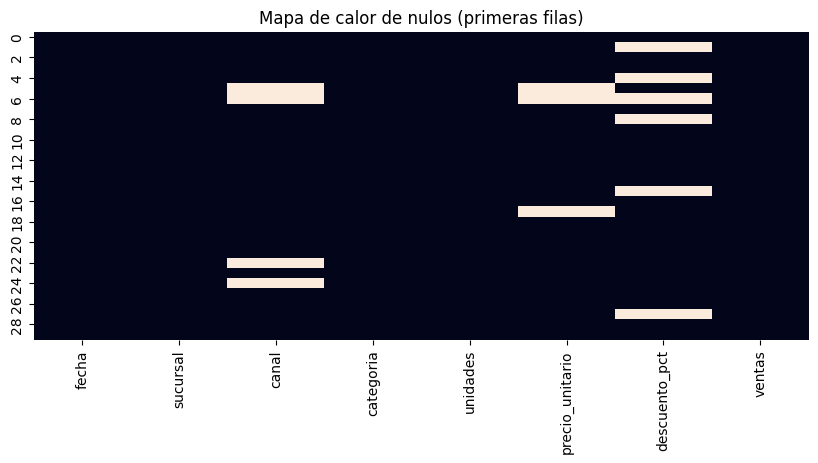

In [28]:
plt.figure(figsize=(10, 4))
sns.heatmap(df_demo.head(30).isnull(), cbar=False)
plt.title("Mapa de calor de nulos (primeras filas)")
plt.show()


<h5 style="color:#1f77b4;">4. Eliminar filas o columnas con dropna().</h5>

In [31]:
df_demo.isnull().sum()

fecha                 0
sucursal              0
canal              3009
categoria             0
unidades              0
precio_unitario    3697
descuento_pct      4640
ventas                0
dtype: int64

Eliminar filas solo si faltan columnas críticas: no aceptamos registros sin precio_unitario ni canal.

In [35]:
df_demo["canal"].unique()

array(['Tienda', 'Mayorista', 'Online', nan], dtype=object)

In [36]:
df_demo["canal"].value_counts()

canal
Tienda       12112
Online       10820
Mayorista     4059
Name: count, dtype: int64

In [32]:
df_drop_criticos = df_demo.dropna(subset=["precio_unitario", "canal"])

print("Filas antes:", df_demo.shape[0])
print("Filas después:", df_drop_criticos.shape[0])


Filas antes: 30000
Filas después: 23690


<h5 style="color:#1f77b4;">5. Imputar datos numéricos con media y mediana, y categóricos con moda o nueva categoría.</h5>

In [37]:
df_demo.isnull().sum()

fecha                 0
sucursal              0
canal              3009
categoria             0
unidades              0
precio_unitario    3697
descuento_pct      4640
ventas                0
dtype: int64

Imputación de datos numéricos<br>
a) Con la media

In [38]:
df_media = df_demo.copy()

df_media["precio_unitario"] = df_media["precio_unitario"].fillna(
    df_media["precio_unitario"].mean()
)

df_media["descuento_pct"] = df_media["descuento_pct"].fillna(
    df_media["descuento_pct"].mean()
)

df_media.isnull().sum()


fecha                 0
sucursal              0
canal              3009
categoria             0
unidades              0
precio_unitario       0
descuento_pct         0
ventas                0
dtype: int64

b) Con la mediana

In [39]:
df_mediana = df_demo.copy()

df_mediana["precio_unitario"] = df_mediana["precio_unitario"].fillna(
    df_mediana["precio_unitario"].median()
)

df_mediana["descuento_pct"] = df_mediana["descuento_pct"].fillna(
    df_mediana["descuento_pct"].median()
)

df_mediana.isnull().sum()


fecha                 0
sucursal              0
canal              3009
categoria             0
unidades              0
precio_unitario       0
descuento_pct         0
ventas                0
dtype: int64

2) Imputación de datos categóricos: Con la moda

In [40]:
df_moda = df_demo.copy()

moda_canal = df_moda["canal"].mode()[0]
df_moda["canal"] = df_moda["canal"].fillna(moda_canal)

df_moda.isnull().sum()


fecha                 0
sucursal              0
canal                 0
categoria             0
unidades              0
precio_unitario    3697
descuento_pct      4640
ventas                0
dtype: int64

<h5 style="color:#1f77b4;">6. Detectar outliers con IQR y Z-score.</h5>

Lo aplicamos a precio_unitario y ventas

Detección de outliers con IQR

In [41]:
import numpy as np

def detectar_outliers_iqr(df, columna):
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1

    limite_inf = Q1 - 1.5 * IQR
    limite_sup = Q3 + 1.5 * IQR

    outliers = df[
        (df[columna] < limite_inf) | (df[columna] > limite_sup)
    ]

    return outliers, limite_inf, limite_sup


In [42]:
out_iqr_precio, li, ls = detectar_outliers_iqr(df_demo, "precio_unitario")

print("Outliers en precio_unitario (IQR):", out_iqr_precio.shape[0])


Outliers en precio_unitario (IQR): 182


Detección de outliers con Z-score

In [43]:
from scipy.stats import zscore

df_z = df_demo.copy()

df_z["z_ventas"] = zscore(df_z["ventas"], nan_policy="omit")

outliers_z = df_z[abs(df_z["z_ventas"]) > 3]

print("Outliers en ventas (Z-score):", outliers_z.shape[0])


Outliers en ventas (Z-score): 197


Comparación rápida

In [44]:
print("IQR outliers (precio_unitario):", out_iqr_precio.shape[0])
print("Z-score outliers (ventas):", outliers_z.shape[0])

IQR outliers (precio_unitario): 182
Z-score outliers (ventas): 197


<p>IQR es más robusto; Z-score es más estadístico. Ninguno es mejor en abstracto: depende del problema.”</p>

<h5 style="color:#1f77b4;">7. Visualizar outliers con boxplots y scatter plots.</h5>

Boxplot

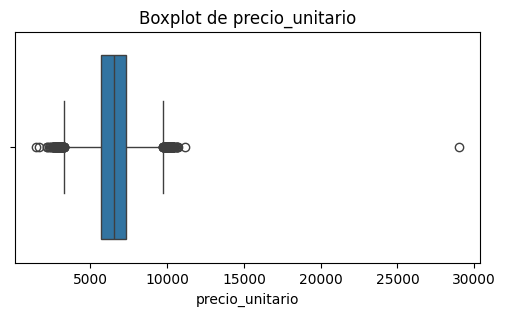

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 3))
sns.boxplot(x=df_demo["precio_unitario"])
plt.title("Boxplot de precio_unitario")
plt.show()


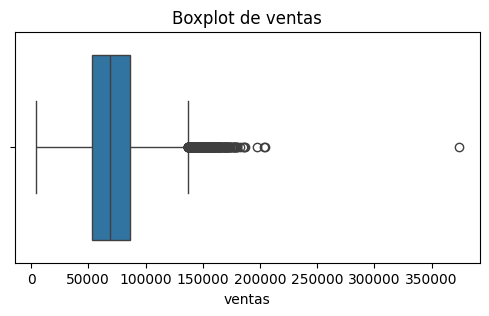

In [46]:
plt.figure(figsize=(6, 3))
sns.boxplot(x=df_demo["ventas"])
plt.title("Boxplot de ventas")
plt.show()


Scatter plot

Scatter simple por índice

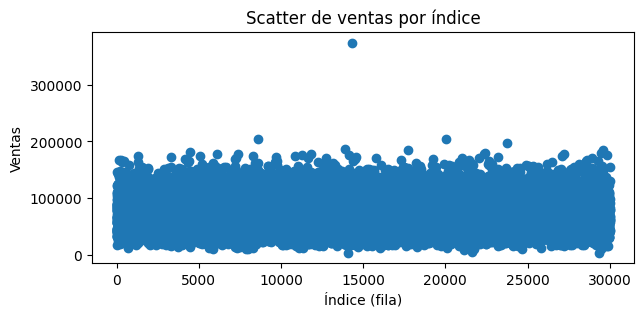

In [47]:
plt.figure(figsize=(7, 3))
plt.scatter(range(len(df_demo)), df_demo["ventas"])
plt.title("Scatter de ventas por índice")
plt.xlabel("Índice (fila)")
plt.ylabel("Ventas")
plt.show()


Scatter entre dos variables

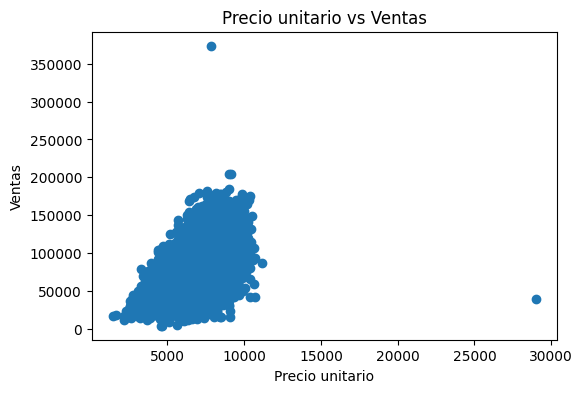

In [48]:
plt.figure(figsize=(6, 4))
plt.scatter(df_demo["precio_unitario"], df_demo["ventas"])
plt.title("Precio unitario vs Ventas")
plt.xlabel("Precio unitario")
plt.ylabel("Ventas")
plt.show()
